In [8]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from tensorflow.keras import backend
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)


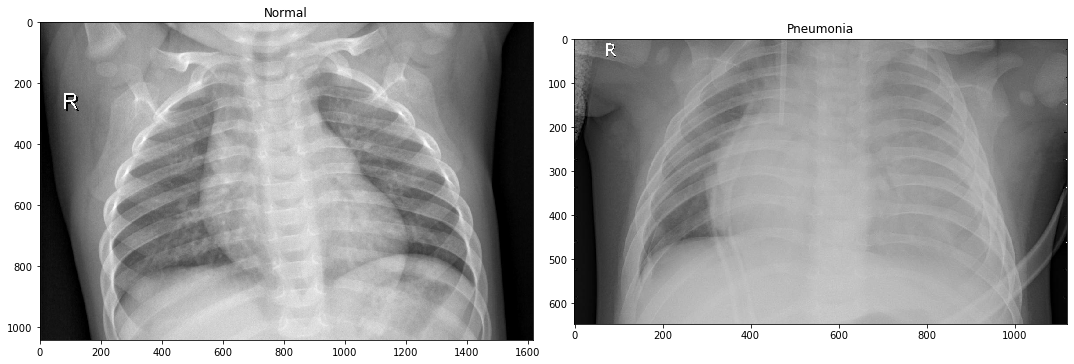

In [9]:
input_path = '../input/chest-xray-pneumonia/chest_xray'


#Show difference between Pneumonia and Normal X-ray



fig, ax = plt.subplots(1,2, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

ax[0].set_title('Normal')
ax[1].set_title('Pneumonia')

ax[0].imshow(plt.imread(input_path+'/test/NORMAL/'+os.listdir(input_path+'/test/NORMAL')[0]), cmap='gray')
ax[1].imshow(plt.imread(input_path+'/test/PNEUMONIA/'+os.listdir(input_path+'/test/PNEUMONIA')[0]), cmap='gray')


In [4]:
for folder in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + '/'+ folder + '/NORMAL'))
    n_infect = len(os.listdir(input_path +'/'+ folder + '/PNEUMONIA'))
    print('Folder: {}, normal images: {}, pneumonia images: {}'.format(folder, n_normal, n_infect))

Folder: train, normal images: 1341, pneumonia images: 3875
Folder: val, normal images: 8, pneumonia images: 8
Folder: test, normal images: 234, pneumonia images: 390


In [17]:
img_dims = 150
epochs = 20
batch_size = 32

In [18]:
  # Data generation objects
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
train_gen = train_datagen.flow_from_directory(
                directory=input_path+'/'+'train', 
              target_size=(img_dims, img_dims), 
              batch_size=batch_size, 
              class_mode='binary', 
              shuffle=True)

test_gen = test_val_datagen.flow_from_directory(
              directory=input_path+'/'+'test', 
              target_size=(img_dims, img_dims), 
              batch_size=batch_size, 
              class_mode='binary', 
              shuffle=True)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path +'/'+ 'test' + cond)):
            img = plt.imread(input_path+'/'+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    print(len(test_data))
    print(len)

624
<built-in function len>


In [20]:
# Using a linear stack of layers
cnn = Sequential()


# First conv block
cnn.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(150,150,3)))
cnn.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPool2D(pool_size=(2, 2)))

# Second conv block
cnn.add(SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2, 2)))

# Third conv block
cnn.add(SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2, 2)))

# Fourth conv block
cnn.add(SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Dropout(rate=0.2))

# Fifth conv block
cnn.add(SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Dropout(rate=0.2))


# FC layer
cnn.add(Flatten())
cnn.add(Dense(units=512, activation='relu'))
cnn.add(Dropout(rate=0.7))
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dropout(rate=0.5))
cnn.add(Dense(units=64, activation='relu'))
cnn.add(Dropout(rate=0.3))

# Output layer
cnn.add(Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [21]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_17 (Separab (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_18 (Separab (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_9 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 37, 37, 32)       

In [22]:
hist = cnn.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/20
163/163 [==============================] - 263s 2s/step - loss: 0.3759 - accuracy: 0.8301 - val_loss: 1.1115 - val_accuracy: 0.6283
Epoch 2/20
163/163 [==============================] - 258s 2s/step - loss: 0.2711 - accuracy: 0.8890 - val_loss: 0.6404 - val_accuracy: 0.6250
Epoch 3/20
163/163 [==============================] - 249s 2s/step - loss: 0.2376 - accuracy: 0.9093 - val_loss: 1.2500 - val_accuracy: 0.6216
Epoch 4/20
163/163 [==============================] - 248s 2s/step - loss: 0.2285 - accuracy: 0.9155 - val_loss: 1.8120 - val_accuracy: 0.6351
Epoch 5/20
163/163 [==============================] - 258s 2s/step - loss: 0.2120 - accuracy: 0.9187 - val_loss: 0.5636 - val_accuracy: 0.6368
Epoch 6/20
163/163 [==============================] - 247s 2s/step - loss: 0.1938 - accuracy: 0.9243 - val_loss: 1.5398 - val_accuracy: 0.6757

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/20
163/163 [==============================] - 246s 2s

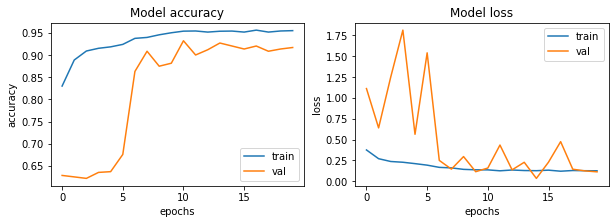

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix,roc_auc_score

preds = cnn.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
roc=roc_auc_score(test_labels,np.round(preds))*100

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')

print('Accuracy: {}%'.format(acc))
print('\nTrue negative: {}'.format(tn))
print('False positive: {}'.format(fp))
print('False negative: {}'.format(fn))
print('True positive: {}'.format(tp))


print('\nPrecision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nROC_AUC Score: {}%'.format(roc))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[187  47]
 [  6 384]]

TEST METRICS ----------------------
Accuracy: 91.50641025641025%

True negative: 187
False positive: 47
False negative: 6
True positive: 384

Precision: 89.0951276102088%
Recall: 98.46153846153847%
F1-score: 93.54445797807551

ROC_AUC Score: 89.1880341880342%

TRAIN METRIC ----------------------
Train acc: 95.53
